In [6]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import anndata as ad
import decoupler as dc
import torch
import gzip
from gtfparse import read_gtf


scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

import os

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.1.4


In [113]:
pa_adata = sc.read_h5ad('/gpfs/home/chewu/project/human_hiv/mra_results/scvinet_scvimtx_narnea.h5ad')
pa_adata = pa_adata[np.where(pa_adata.obs['class']=='ExN')[0]].copy()
sc.pp.filter_cells(pa_adata, min_genes = 10)
sc.pp.filter_genes(pa_adata, min_cells= 10)

In [114]:
pa_adata

AnnData object with n_obs × n_vars = 53077 × 1416
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet', 'cell_family', 'condition'
    var: 'n_cells'
    uns: 'gex_data', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'pes'
    obsp: 'connectivities', 'distances'

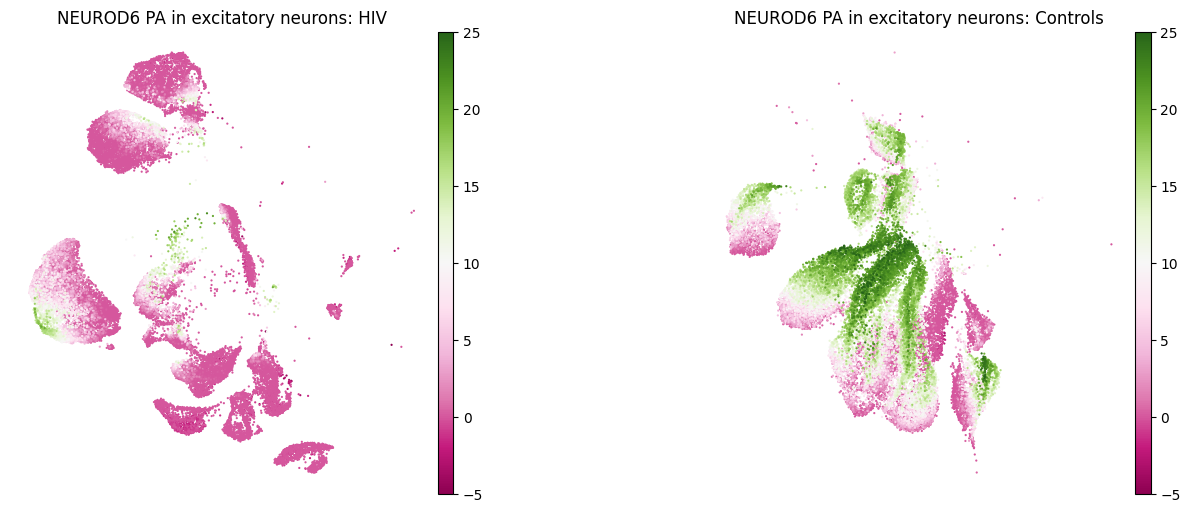

In [152]:
ncols = 2
nrows = 1
figsize = 6
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
gene="NEUROD6"
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(
    pa_adata[np.where((pa_adata.obs.condition=='hiv')&(pa_adata.obs['class']=='ExN'))[0]],
    color=[gene],
    frameon=False,
    size=10,
    cmap='PiYG',vcenter=10,vmin=-5,vmax=25,ax=axs[0],show=False,title=gene+' PA in excitatory neurons: HIV'
)
sc.pl.umap(
    pa_adata[np.where((pa_adata.obs.condition=='ctrl')&(pa_adata.obs['class']=='ExN'))[0]],
    color=[gene],
    frameon=False,
    size=10,
    cmap='PiYG',vcenter=10,vmin=-5,vmax=25,ax=axs[1],title=gene+' PA in excitatory neurons: Controls'
)

In [115]:
pa_adata.obs['subclass'].unique()

['L2-3 IT', 'L3-5 IT-1', 'L3-5 IT-2', 'L3-5 IT-3', 'L6 IT-1', 'L6 CT', 'L6B', 'L6 IT-2', 'L5-6 NP', 'L5 ET']
Categories (10, object): ['L2-3 IT', 'L3-5 IT-1', 'L3-5 IT-2', 'L3-5 IT-3', ..., 'L6 CT', 'L6 IT-1', 'L6 IT-2', 'L6B']

In [117]:
pa_adata.layers['pes']

array([[-0.41144217, -0.48022169, -0.42975567, ..., -0.40597914,
        -0.46440459, -0.24976184],
       [-0.30760891, -0.46868553, -0.31334021, ..., -0.31187198,
        -0.62687334, -0.19212645],
       [-0.29046984, -0.63332362, -0.39416829, ..., -0.41045819,
        -0.44293611, -0.19742217],
       ...,
       [-0.45905171, -0.58825212, -0.40074073, ..., -0.47856132,
        -0.6851622 , -0.18381162],
       [-0.30084047, -0.57057353, -0.3218521 , ..., -0.35281713,
        -0.5483318 , -0.07996287],
       [-0.40340817, -0.65913511, -0.39431234, ..., -0.59601178,
        -0.68673897, -0.17563764]])

In [118]:
pa_adata.layers['pes_counts']=((10**2)*(pa_adata.layers["pes"])).astype(np.int32)
#pa_adata.layers["pes_counts"]

In [119]:
pa_adata.layers['pes_counts']

array([[-41, -48, -42, ..., -40, -46, -24],
       [-30, -46, -31, ..., -31, -62, -19],
       [-29, -63, -39, ..., -41, -44, -19],
       ...,
       [-45, -58, -40, ..., -47, -68, -18],
       [-30, -57, -32, ..., -35, -54,  -7],
       [-40, -65, -39, ..., -59, -68, -17]], dtype=int32)

In [138]:
scvi.model.SCVI.setup_anndata(pa_adata, layer='pes_counts',
                              categorical_covariate_keys=['sample'],
                              #continuous_covariate_keys=["Age at Death"]
                             )
model = scvi.model.SCVI(pa_adata, gene_likelihood="nb")
model.train()
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
pa_adata.obsm[SCVI_LATENT_KEY] = latent
sc.pp.neighbors(pa_adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(pa_adata, min_dist=0.3)
sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(
    pa_adata,
    color=["subclass"],
    frameon=False,
    size=5
)

/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[pes_counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/scvi/model/_scvi.py:161: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.scvi_ve

Epoch 1/151:   0%|                                                                                                                                       | 0/151 [00:00<?, ?it/s]

ValueError: Expected parameter loc (Tensor of shape (128, 10)) of distribution Normal(loc: torch.Size([128, 10]), scale: torch.Size([128, 10])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [121]:
for layer in pa_adata.layers:
    print(f"NaN in {layer}:", np.any(np.isnan(pa_adata.layers[layer])))
    print(f"Inf in {layer}:", np.any(np.isinf(pa_adata.layers[layer])))

NaN in pes: False
Inf in pes: False
NaN in pes_counts: False
Inf in pes_counts: False


In [122]:
pd.DataFrame(data=pa_adata.layers['pes'],columns=pa_adata.var_names.T)

,AATF,ADNP,ADNP2,AEBP2,AFF1,AFF3,AFF4,AHCTF1,AHR,ALX3,...,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM7,ZUP1,ZXDB,ZXDC,ZZEF1,ZZZ3
0,-0.411442,-0.480222,-0.429756,0.456137,-0.229578,0.323182,-0.107945,0.276879,0.180473,-0.409059,...,0.440198,-0.486878,-0.030306,-0.383823,-0.529438,-0.287489,-0.054372,-0.405979,-0.464405,-0.249762
1,-0.307609,-0.468686,-0.313340,0.272466,-0.065925,0.193837,-0.567922,0.244490,0.015658,-0.055689,...,0.403655,-0.554844,-0.035568,-0.138142,-0.441813,-0.227648,-0.276404,-0.311872,-0.626873,-0.192126
2,-0.290470,-0.633324,-0.394168,0.496830,-0.207255,0.297389,-0.254974,0.343503,-0.000146,-0.269277,...,0.535489,-0.589468,0.029222,-0.295907,-0.544946,-0.263943,-0.442020,-0.410458,-0.442936,-0.197422
3,-0.356756,-0.638869,-0.395290,0.541981,-0.166481,0.355019,-0.197092,0.336979,0.018827,-0.346883,...,0.505581,-0.574236,0.042194,-0.376730,-0.687457,-0.289320,-0.385108,-0.474811,-0.337216,-0.197059
4,-0.382878,-0.503148,-0.359945,0.312573,-0.096943,0.226232,-0.457968,0.268936,0.046434,-0.110204,...,0.429654,-0.522344,-0.039234,-0.176393,-0.471894,-0.271813,-0.228712,-0.387483,-0.634243,-0.205065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53072,-0.322145,-0.443727,-0.462757,0.373438,-0.299765,0.224142,0.293049,0.286116,-0.062073,-0.260165,...,0.428132,-0.272934,0.153898,-0.257758,-0.168307,-0.442275,-0.653881,-0.468638,-0.050950,-0.275633
53073,-0.426377,-0.542484,-0.397241,0.251275,-0.259038,0.211557,-0.223316,0.236911,0.058693,-0.139861,...,0.446310,-0.455368,0.017460,-0.279399,-0.212305,-0.023895,-0.469375,-0.551363,-0.615288,-0.180637
53074,-0.459052,-0.588252,-0.400741,0.245173,-0.259998,0.183663,-0.271709,0.214386,0.068245,-0.106583,...,0.431580,-0.411381,0.006956,-0.235800,-0.092170,-0.050829,-0.364432,-0.478561,-0.685162,-0.183812
53075,-0.300840,-0.570574,-0.321852,0.286331,-0.191453,0.212844,-0.326203,0.119679,0.084301,-0.109475,...,0.314893,-0.379762,0.009959,-0.365444,-0.012001,-0.031908,-0.477254,-0.352817,-0.548332,-0.079963


In [123]:
import umap

In [124]:
reducer = umap.UMAP()

In [125]:
embedding = reducer.fit_transform(pd.DataFrame(data=pa_adata.layers['pes'],columns=pa_adata.var_names.T))
embedding.shape

(53077, 2)

<AxesSubplot: >

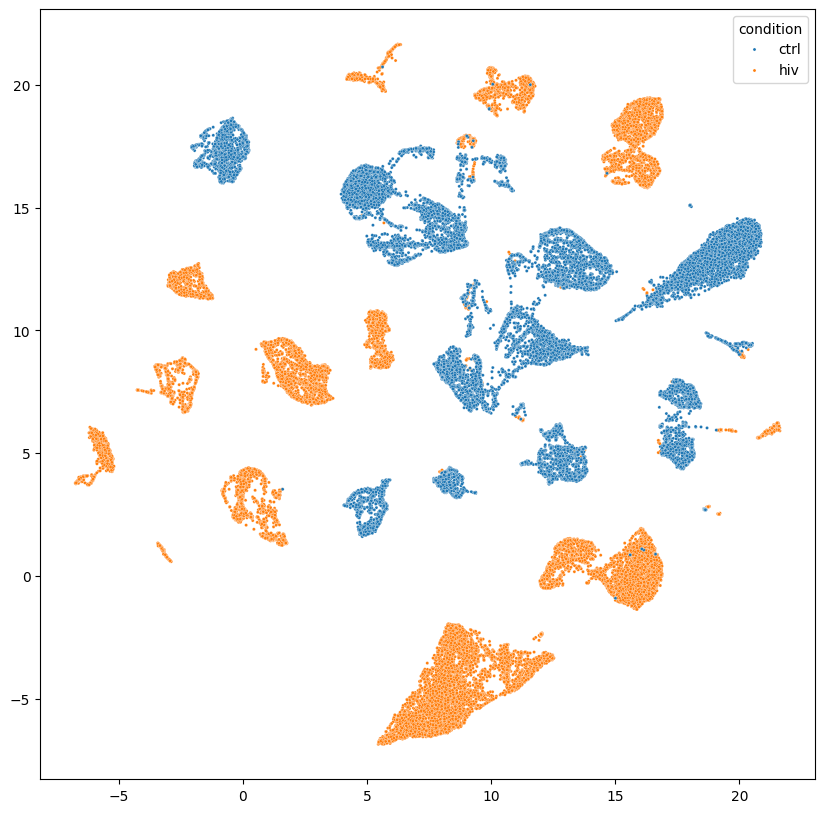

In [139]:
plt.subplots(figsize=(10,10))
sns.scatterplot(
   x= embedding[:, 0],
   y= embedding[:, 1],hue=pa_adata.obs.condition,s=5)

<AxesSubplot: >

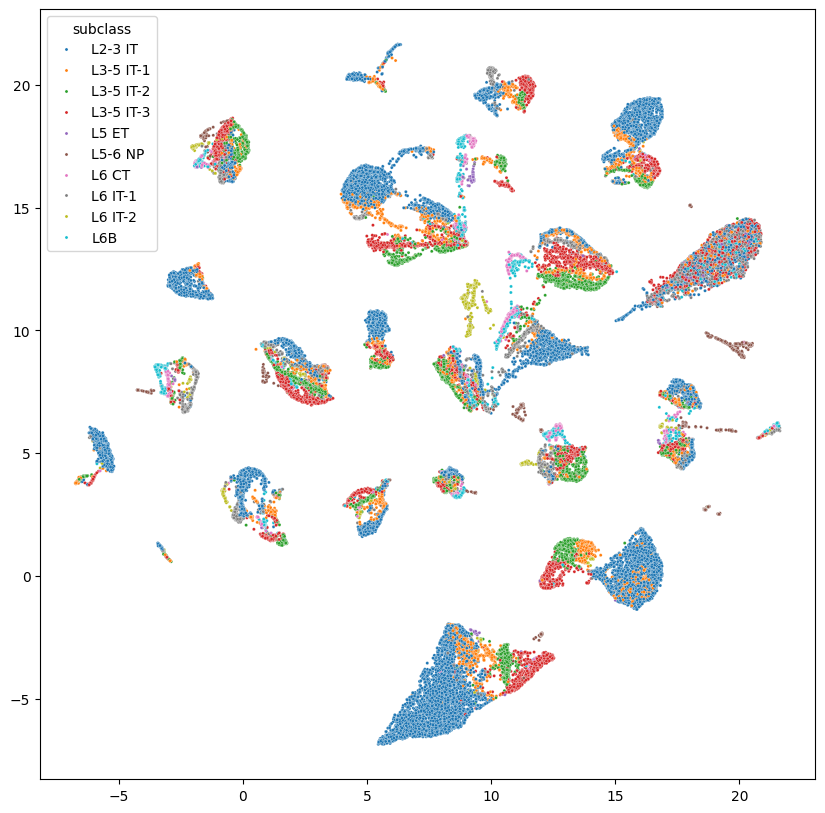

In [141]:
plt.subplots(figsize=(10,10))
sns.scatterplot(
   x= embedding[:, 0],
   y= embedding[:, 1],hue=pa_adata.obs.subclass,s=5)